In [16]:
"""
1.
Using data from one particular day, and given environmental data, run
the optimization.
Since the environmental data does not match the data used, and the decision variables
will probably differ from the ones used during that day, the outputs will drift from 
the experimental values. 

After one step is completed, the problem can be repeated for the next step either 
using the previous step outputs, or use the experimental values to "reconducir" problem

Start with the MINLP problem, and then try fixing the integer variables and solving the
NLP problem.

Specific steps for implementation:
- prepare the data
- implement initialization of MINLP problem class
- implement get_bounds method
- implement fitness method
- implement algorithm to solve multiple steps of the problem
- implement visualization of the results: 
    for each step, plot the current values with solid lines, and the expected
    ones with dashed lines. After each step, make the prior expected values that now are replaced,
    stay in the plot with a gray with opacity that gets dimmer with each step.
"""

"""
After
- streamline process of getting environment variables current value and predictions using the Bonilla API
- Explore tackling the MINLP as multiple NLP problems

"""


'\nAfter\n- streamline process of getting environment variables current value and predictions using the Bonilla API\n- Explore tackling the MINLP as multiple NLP problems\n\n'

### TODOs

- [ ] Support different number of updates per decision variable. This requires to reestructure the decision vector, to, instead of grouping by steps, group by variables. Affects `get_bounds`, and the the outer loop in `fitness`. Psudo-code:
```python

n_evals_mod: int = int(opt_horizon_duration/model_sample_time) # round? truncate? ceil?
updates_per_input: dict[str, int] = {
    'input1': 24,
    'input2': 48,
    'input3': 24,
}
# Validation would include: min value updates = 1, max value updates = n_evals_mod
...

decision_dict: dict[str, np.ndarray] = {}
for input_name, num_updates in updates_per_input.items():
    span = n_evals_mod / num_updates
    decision_dict[input_name] = np.full((n_evals_mod, ), np.nan, dtype=input_dtype)
    for k in num_updates:
        decision_dict[input_name][k*span:(k+1)*span] = x[k]

for step_idx in range(n_evals_mod):
    model.step(...)
```

#### Varias reflexiones (de un batracio?)

- El problema de usar $q_{sf}$ como variable de decisión en lugar de $T_{sf,out}$, es que con la tasa de actualización actual de la capa de optimización, fuerza a encontrar un **único** caudal válido para una ventana temporal amplia. En cambio, una referencia de temperatura permite variaciones de caudal para cada muestreo del modelo. Esto hace mucho más factible tener tiempos de muestreo muy diferentes entre modelo y optimización ($T_{s,opt} \gg T_{s,mod}$)
- Un posible parche a este problema (mientras se decide si revertir el cambio de variable de decisión) que también puede ser una contribución interesante a la estrategia de optimización es: soportar distintas tasas de actualización para distintas variables de decisión. Para ello es necesario reestructurar el vector de decisión:

    $x = \left[ [1,...,n_{updates,x_1}]_{x_{1}}, [1,...,n_{updates,x_2}]_{x_{2}}, ..., [1,...,n_{updates,x_{Ndec.vars}} ]_{x_{Ndec.vars}} \right]$

    s.a. $n_{dec.var \: i, mín} \le n_{dec.var\: i} \le n_{dec.var \: i, máx}$
    
    donde: 
    
    $n_{dec.var \: i, mín} = 1 \: o \: n_{horizon}$ 

    $n_{dec.var \: i, máx} = n_{horizon} \times T_{s,opt}/T_{s,mod}$ 

- [x] Probablemente como ya he hecho en otros sitios, en lugar de partir estableciendo un número _arbitratio_ de actualizaciones de la optimización ($n_{horizon}$), sería más apropiado establecer una duración temporal, y en base al período de optimización, calcular $n_{horizon}$: $n_{horizon} = T_{horizon} / T_{s,opt}$

##### Secuencias válidas

**UPDATE:** Hecho, disponible en `solarmed_optimization.path_explorer.utils`

Cuando el problema a resolver sea nNLP (n number of Non Linear Problems), se pueden descartar todos los paths donde la FSM no siga cierta secuencia. Por ejemplo, solo es válida la secuencia GEN.VAC* -> STARTING UP/IDLE* -> ACTIVE, no sería válido / no tiene sentido la secuencia GEN.VAC* -> IDLE -> OFF, porque para eso nos quedamos en OFF desde un principio.

Esto es algo que probablemente no se limite al caso nNLP, deberíamos filtrar los paths posibles para quitar todas las secuencias no válidas y así reducir el espacio de soluciones posibles para el problema MINLP. 

Nota: El asterisco representa que ese estado podría abarcar más de un paso de optimización, pero debe permanecerse en ese estado y no otro que no sea el que se indica. 

Definición 'formal' de secuencias válidas:

**SF-TS**
1. HEATING_UP_SF* -> SF_HEATING_TS

**MED**
1. IDLE* -> STARTING_UP* -> ACTIVE
2. GEN.VAC* -> STARTING_UP* -> ACTIVE


##### Integrar problema MINLP y NLP en la misma interfaz

Intentar usar la misma clase para problema MINLP y NLP, que el cambio sea solo un atributo / argumento de entrada.

A tener en cuenta:

- NLP debe implementar gradiente
- Variables lógicas en NLP se restringen a mantener el valor dado para ese step (lower and upper bound igual y mapeo al estado de ese step)
- V



In [17]:
from pathlib import Path
import math
from loguru import logger
import json
import hjson

import copy
import numpy as np

# Visualization packages
from phd_visualizations import save_figure
from phd_visualizations.constants import generate_plotly_config
from phd_visualizations.test_timeseries import experimental_results_plot

from solarmed_modeling.utils import data_preprocessing, data_conditioning
from solarmed_modeling.solar_med import EnvironmentParameters

# auto reload modules
%load_ext autoreload
%autoreload 2

# Paths definition
output_path: Path = Path("../results")
data_path: Path = Path("../data")
fsm_data_path: Path = Path("../results")

date_str: str = "20230707_20230710" # '20230630'
filenames: list[str] = [f'{date_str}_solarMED.csv', f'{date_str}_MED.csv', ]

sample_time_mod: int = 400 # seconds
sample_time_mod_str: str = f'{sample_time_mod}s'

optim_window_size: int = 3600 * 8 # 12 hours
default_sample_time_opt: int = 3600 # 1 hour

cost_w: float = EnvironmentParameters.cost_w
cost_e: float = EnvironmentParameters.cost_e



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
n_evals_mod: int = math.ceil(optim_window_size  / sample_time_mod)
default_n_dec_var_updates: int = optim_window_size // default_sample_time_opt # Every hour


### Pre-processing

In [19]:
data_paths = [data_path / f"datasets/{fn}" for fn in filenames]

# 20230707_20230710 data does not include solar irradiation
# An alternative source from http://heliot.psa.es/meteo_psa_2022 is used for the solar irradiance
data_paths.append(data_path / f"datasets/{date_str}_env.csv")

# 20230707_20230710 does not include continuous seawater temperature and salinity
# An alternative source from https://doi.org/10.25423/CMCC/MEDSEA_ANALYSISFORECAST_PHY_006_013_EAS8 is used for seawater temperature and salinity
data_paths.append(data_path / "datasets/external_data/env_20220524_20240524.csv")

with open( data_path / "variables_config.hjson") as f:
    vars_config = hjson.load(f)
    
with open(data_path/"plot_config_validation.hjson") as f:
    plot_config = hjson.load(f)
    
# Load data and preprocess data
df = data_preprocessing(data_paths, vars_config, sample_rate_key=sample_time_mod_str)

# Condition data
df = data_conditioning(df, sample_rate_numeric=sample_time_mod, vars_config=vars_config, )


2024-11-21 19:13:52.702 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id RE-SF-001 not found in dataframe columns.
2024-11-21 19:13:52.710 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id PK-MED-E03-pa not found in dataframe columns.
2024-11-21 19:13:52.711 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id FT-SF-003 not found in dataframe columns.
2024-11-21 19:13:52.712 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id FT-SF-005 not found in dataframe columns.
2024-11-21 19:13:52.713 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id FT-SF-006 not found in dataframe columns.
2024-11-21 19:13:52.714 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id FT-SF-007 not found in dataframe columns.
2024-11-21 19:13:52.715 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:81 - Signal id FT

In [20]:
df = df.rename(columns={
    # First rename the original columns
    "I": "I_orig", "Tamb": "Tamb_orig",
    "Tmed_c_in": "Tmed_c_in_orig", "wmed_f": "wmed_f_orig",

    # Then rename the new columns
    "GHI_Wm2": "I", "Tamb_degC": "Tamb",
    "DNI_Wm2": "DNI", "DHI_Wm2": "DHI",
    "so": "wmed_f", "thetao": "Tmed_c_in"
})

# There should be no duplicates
# for col in df.columns:
#     print(col) if col in ["Tmed_c_in", "Tamb", "I", "wmed_f"] else None

display(df.head())


,qmed_s,qts_dis_original,SC-AQU-P102,Tts_h_out,Tts_c_in,ZT-AQU-TCV102,Tamb_orig,qts_src_original,qsf,Tts_c_t,...,Jmed,Jtotal,Pth_sf,Pth_hx_p,Pth_ts_src,Pth_hx_s,Pth_ts_dis,sf_active,med_active,ts_active
time,,,,,,,,,,,,,,,,,,,,,
2023-07-07 00:00:00+00:00,0.0,0.032902,0.0,73.219231,55.562454,0.527879,22.621204,0.0,0.0,83.630384,...,7.004292,7.004292,-0.0,-0.0,0.0,0.0,0.402996,False,True,False
2023-07-07 00:06:40+00:00,0.0,0.032902,0.0,73.219231,55.562454,0.527879,22.621204,0.0,0.0,83.630384,...,7.004292,7.004292,-0.0,-0.0,0.0,0.0,0.402996,False,True,False
2023-07-07 00:13:20+00:00,0.0,0.032902,0.0,73.219231,55.562454,0.527879,22.621204,0.0,0.0,83.630384,...,7.004292,7.004292,-0.0,-0.0,0.0,0.0,0.402996,False,True,False
2023-07-07 00:20:00+00:00,0.0,0.032902,0.0,73.219231,55.562454,0.527879,22.621204,0.0,0.0,83.630384,...,7.004292,7.004292,-0.0,-0.0,0.0,0.0,0.402996,False,True,False
2023-07-07 00:26:40+00:00,0.0,0.032902,0.0,73.219231,55.562454,0.527879,22.621204,0.0,0.0,83.630384,...,7.004292,7.004292,-0.0,-0.0,0.0,0.0,0.402996,False,True,False


In [21]:
# Visualize the data


### Problem definition

In [22]:
# class MinlpProblem:


#     def __init__(self):
#         # Dado un estado inicial
#         # n_horizon
#         # tiempo de muestreo modelo
#         # tiempo de muestreo de optimización
#         # predicciones de variables de entorno para 
#         # Instancia ya inicializada de solarMED? O argumentos para poder inicializarla?
#         pass

#     def get_bounds(self):
#         pass
    
#     def fitness(self, x):
#         pass


In [23]:
# from pydantic import BaseModel, ConfigDict, model_validator, Field, PrivateAttr
# from typing import Self, Type
from dataclasses import dataclass, fields

@dataclass
class EnvironmentVariables:
    """
    Simple class to make sure that the required environment variables are passed
    
    All the variables should be 1D arrays with as many elements as the horizon of the optimization problem
    """
    # n_horizon: int
    
    Tmed_c_in: np.ndarray[float]  # Seawater temperature
    Tamb: np.ndarray[float]  # Ambient temperature
    I: np.ndarray[float]  # Solar radiation
    
    cost_w: np.ndarray[float] # Cost of water, €/m³ 
    cost_e: np.ndarray[float] # Cost of electricity, €/kWhe
    
    wmed_f: np.ndarray[float] = None  # Seawater salinity
    
    def __post_init__(self):
        # Validate that all the environment variables have the same length
        assert all([len(getattr(self, var_id)) == len(self.Tmed_c_in) for var_id in ["Tamb", "I", "cost_w", "cost_e"]]), \
            "All the environment variables should have the same length, which should be the number of model evaluations in the optimization window (optim_window_size // sample_time_mod)"
    
#     _fields_to_dump: list[str] = PrivateAttr(default_factory=lambda: ["Tmed_c_in", "Tamb", "I"])
#     _fields_to_validate: list[str] = PrivateAttr(default_factory=lambda:["Tmed_c_in", "Tamb", "I", "cost_w", "cost_e"])
    
    # model_config = ConfigDict(arbitrary_types_allowed=True)
    
    
#     @model_validator(mode='after')
#     def check_fields_to_dump_len_matches_n_horizon(self) -> Self:
#         assert all([len(getattr(self, var_id)) == self.n_horizon for var_id in self._fields_to_validate]), \
#             "All the environment variables should have the same length as the horizon of the optimization problem"
    
#     def model_dump_at_index(self, idx: int) -> dict[str, float]:
#         return {var_id: getattr(self, var_id)[idx] for var_id in self._fields_to_dump}

@dataclass
class DecisionVariables:
    """
    Simple class to make sure that the required decision variables are passed
    to the model instance
    
    Variables should be scalars to pass for the current step
    
    The idea is to call the step method just by doing **dec_vars (where dec_vars is an instance of this class)
    """
    # Logical / integers
    sf_active: bool #  Solar field state (off, active)
    ts_active: bool #  Thermal storage state (off, active)
    med_active: bool #  MED heat source state (off, active)
    med_vac_state: int #  MED vacuum system state (off, low, high)
    # Real
    qsf: float #  Solar field flow -> Actual optimization output will be the outlet temperature (`Tsf,out`) after evaluating the inverse solar field model.
    qts_src: float #  Thermal storage recharge flow.
    qmed_s: float #  MED heat source flow.
    qmed_f: float #  MED feed flow.
    Tmed_s_in: float #  MED heat source inlet temperature.
    Tmed_c_out: float #  MED condenser outlet temperature.

@dataclass
class DecisionVariablesUpdates:
    sf_active: int = default_n_dec_var_updates
    ts_active: int = default_n_dec_var_updates
    med_active: int = default_n_dec_var_updates
    med_vac_state: int = default_n_dec_var_updates
    qsf: int = default_n_dec_var_updates
    qts_src: int = default_n_dec_var_updates
    qmed_s: int = default_n_dec_var_updates
    qmed_f: int = default_n_dec_var_updates
    Tmed_s_in: int = default_n_dec_var_updates
    Tmed_c_out: int = default_n_dec_var_updates
    
    def __post_init__(self):
        # Validate that SfTs FSM related decision varaiables have the same number of updates
        assert self.sf_active == self.ts_active, "Solar field and thermal storage logical variables should have the same number of updates"
        
        # Validate that MED FSM related decision variables have the same number of updates
        assert self.med_active == self.med_vac_state, "MED logical variables should have the same number of updates"
        
        # TODO: Would be good to validate that the number of updates is:

# Check errors during development
assert [field.name for field in fields(DecisionVariables)] == [field.name for field in fields(DecisionVariablesUpdates)], \
    "Attributes of DecisionVariables should exactly match attributes in DecisionVariableUpdates"


### Problem evaluation

In [24]:
from solarmed_modeling.solar_med import (SolarMED, 
                                         EnvironmentParameters,
                                         ModelParameters,
                                         FixedModelParameters,
                                         FsmParameters,
                                         FsmInternalState)
from solarmed_modeling.fsms import MedState, SfTsState
from solarmed_modeling.fsms.med import FsmParameters as MedFsmParams
from solarmed_modeling.fsms.sfts import FsmParameters as SftsFsmParams

# sample_time_opt: int = 1 * 3600 # 1 hour
# n_horizon: int = 5 # n_horizon · sample_time_opt = 5 hours ahead, with updates every 1 hour

env_params: EnvironmentParameters = EnvironmentParameters()
fixed_model_params: FixedModelParameters = FixedModelParameters()
model_params: ModelParameters = ModelParameters()
fsm_params: FsmParameters = FsmParameters(
    med=MedFsmParams(
        vacuum_duration_time = 1*3600, # 1 hour
        brine_emptying_time = 30*60,   # 30 minutes
        startup_duration_time = 20*60, # 20 minutes
        off_cooldown_time = 12*3600,   # 12 hours
        active_cooldown_time = 3*3600, # 3 hours
    ),
    sf_ts=SftsFsmParams(
        recirculating_ts_enabled = False,
        idle_cooldown_time = 1*3600,   # 1 hour
    )
)
fsm_internal_states: FsmInternalState = FsmInternalState()
fsm_valid_sequences: dict[ str, list[list[int]] ] = {
    'MED': [
        [MedState.IDLE.value, MedState.STARTING_UP.value, MedState.ACTIVE.value],
        [MedState.GENERATING_VACUUM.value, MedState.STARTING_UP.value, MedState.ACTIVE.value],
    ],
    'SFTS': [
        [SfTsState.HEATING_UP_SF.value, SfTsState.SF_HEATING_TS.value],
    ]
}

# Initialize model
idx_start: int = 3
span = math.ceil(600 / sample_time_mod) # 600 s

model = SolarMED(
    use_models=True,
    use_finite_state_machine=True,
    resolution_mode='constant-water-props',
    sample_time=sample_time_mod,
    env_params=env_params,
    fixed_model_params=fixed_model_params,
    model_params=model_params,
    fsms_params=fsm_params,
    fsms_internal_states=fsm_internal_states,
    
    # Initial states
    ## Thermal storage
    Tts_h=[df['Tts_h_t'].iloc[idx_start], df['Tts_h_m'].iloc[idx_start], df['Tts_h_b'].iloc[idx_start]], 
    Tts_c=[df['Tts_c_t'].iloc[idx_start], df['Tts_c_m'].iloc[idx_start], df['Tts_c_b'].iloc[idx_start]],
    
    ## Solar field
    Tsf_in_ant=df['Tsf_in'].iloc[idx_start-span:idx_start].values,
    qsf_ant=df['qsf'].iloc[idx_start-span:idx_start].values,
)
assert SolarMED(**model.dump_instance()), "Model instance should be dumpable without errors"

# Initialize environment variables
ds = df.iloc[idx_start:idx_start+n_evals_mod]
env_vars: EnvironmentVariables = EnvironmentVariables(
    I=ds['I'].values,
    Tamb=ds['Tamb'].values,
    Tmed_c_in=ds['Tmed_c_in'].values,
    cost_w=np.ones((n_evals_mod, )) * cost_w,
    cost_e=np.ones((n_evals_mod, )) * cost_e,
)

# Initialize decision variables updates
dec_var_updates = DecisionVariablesUpdates(
    qsf = 24,
)


In [25]:
from enum import Enum
import pandas as pd

class VarIdsOptimToFsmsMapping(Enum):
    """
    Mapping between optimization integer decision variable ids and finite state
    machines ones. 
    Using an Enum allows for bi-directional lookups compared to a dictionary
    
    Structure:
    optim_var_id = fsm_var_id
    
    Examples:
    # Convert from optim id to fsm id
    print(f"optim_id: sf_active -> fsm id: {VarIdsOptimToFsmsMapping.sf_active.value}")

    # Convert from fsm id to optim id
    print(f"fsm id: qsf -> optim_id: {VarIdsOptimToFsmsMapping('qsf').name}")
    """
    sf_active = "qsf"
    ts_active = "qts_src"
    med_active = "med_active"
    med_vac_state = "med_vacuum_state"

@dataclass
class FsmData:
    metadata: dict
    paths_df: pd.DataFrame
    valid_inputs: list[list[list[float]]]
    

In [28]:
from dataclasses import dataclass, asdict, fields
from solarmed_optimization.path_explorer.utils import import_results
from solarmed_optimization.utils import forward_fill_resample, downsample_by_segments
import numpy as np
from typing import Type

    
# Step from SolarMED
# def step(
#     self,
#     qts_src: float,  # Thermal storage decision variables
#     qsf: float, # Solar field decision variables
#     qmed_s: float, qmed_f: float, Tmed_s_in: float, Tmed_c_out: float,  # MED decision variables
#     Tmed_c_in: float, Tamb: float, I: float, wmed_f: float = None,  # Environment variables
#     med_vacuum_state: int | MedVacuumState = 2,  # Optional, to provide the MED vacuum state (OFF, LOW, HIGH)
# ) -> None:

# To be checked, ca
    

@dataclass
class MinlpProblem:
    """
    x: decision vector.
    - shape: ( n inputs x n horizon )
    - structure:
        X = [x[0,0] x[1,0] x[2,0] ... x[Ninputs,0], ... x[0,Nhorizon] ... x[Ninputs,Nhorizon]]
    
    - Decision vector components: See `DecisionVariables`  
    - Environment variables: See `EnvironmentVariables`
    """

    model: SolarMED  # SolarMED model instance
    optim_window_size: int  # Optimization window size in seconds
    env_vars: EnvironmentVariables # Environment variables
    dec_var_updates: DecisionVariablesUpdates # Decision variables updates
    fsm_med_data: FsmData # FSM data for the MED system
    fsm_sfts_data: FsmData # FSM data for the SFTS systems
    
    # Computed attributes
    x: np.ndarray[float] = None # Decision variables values vector
    dec_var_ids: list[str] = None # All decision variables ids
    dec_var_int_ids: list[str] = None # Logical / integer decision variables ids
    dec_var_real_ids: list[str] = None  # Real decision variables ids
    dec_var_dtypes: list[Type] = None  # Decision variable data types
    ni: int = None # Number of logical / integer decision variables
    nr: int = None # Number of real decision variables
    integer_dec_vars_mapping: dict[str, np.ndarray[list[int]]] = None # Mapping from integer decision variables to FSMs inputs
    model_dict: dict = None # SolarMED model dumped instance
    n_evals_mod: int = None # Number of model evaluations per optimization window
    sample_time_mod: int = None # Model sample time
    
    def __init__(self, 
                 model: SolarMED,
                 optim_window_size: int,
                 dec_var_updates: DecisionVariablesUpdates,
                 env_vars: EnvironmentVariables,
                 fsm_valid_sequences: dict[ str, list[list] ],
                 fsm_data_path: Path = Path("../results"),):

        self.optim_window_size = optim_window_size
        self.dec_var_updates = dec_var_updates
        self.env_vars = env_vars
        
        self.model_dict = model.dump_instance()
        self.model = SolarMED(**self.model_dict) # To make sure we don't modify the original instance
        
        self.sample_time_mod = self.model.sample_time
        self.n_evals_mod = math.ceil(optim_window_size  / sample_time_mod)
        
        self.dec_var_ids, self.dec_var_dtypes = zip(*[(field.name, field.type) for field in fields(DecisionVariables)])
        self.dec_var_int_ids: list[str] = [var_id for var_id, var_type in zip(self.dec_var_ids, self.dec_var_dtypes) if var_type in [bool, int]]
        self.dec_var_real_ids: list[str] = [var_id for var_id, var_type in zip(self.dec_var_ids, self.dec_var_dtypes) if var_type is float]
        self.ni = len(self.dec_var_int_ids) # TODO: Probably needs to change to use same name as PyGMO
        self.nr = len(self.dec_var_real_ids) # TODO: Probably needs to change to use same name as PyGMO
        self.n_dec_vars = self.ni + self.nr
        self.size_dec_vector = np.sum([getattr(dec_var_updates, var_id) for var_id in self.dec_var_ids])
        
        # if fsm_data is not None:
        #     self.fsm_med_data = fsm_data
        # else:
        
        system: str = 'MED'
        n_horizon = dec_var_updates.med_active
        paths_df, valid_inputs, metadata = import_results(
            paths_path=fsm_data_path, system=system, n_horizon=n_horizon,
            return_metadata=True, return_format="value",
            params={
                'valid_sequences': fsm_valid_sequences[system], 
                "sample_time": optim_window_size // n_horizon,
                **asdict(model.fsms_params.med)
            }, 
        )
        self.fsm_med_data = FsmData(metadata=metadata, paths_df=paths_df, valid_inputs=np.array(valid_inputs))

        system: str = 'SFTS'
        n_horizon = dec_var_updates.sf_active
        paths_df, valid_inputs, metadata = import_results(
            paths_path=fsm_data_path, system=system, n_horizon=n_horizon,
            return_metadata=True, return_format="value",
            params={
                'valid_sequences': fsm_valid_sequences[system], 
                "sample_time": optim_window_size // n_horizon,
                **asdict(model.fsms_params.sf_ts), 
            },
        )
        self.fsm_sfts_data = FsmData(metadata=metadata, paths_df=paths_df, valid_inputs=np.array(valid_inputs))


    def __post_init__(self, ) -> None:
        logger.info(f"""{self.get_name()} initialized.
                    - Size of decision vector: {self.size_dec_vector} elements
                    - Decision variable ids: {self.dec_var_ids}
                    - Number of updates per dec.var: {[getattr(dec_var_updates, var_id) for var_id in self.dec_var_ids]}
                    - other...""")

    def get_bounds(self, readable_format: bool = True) -> tuple[np.ndarray, np.ndarray]:
        """This method will return the box-bounds of the problem. 
        - Infinities in the bounds are allowed.
        - The order of elements in the bounds should match the order of the variables in the decision vector (`dec_var_ids`)
            
        Decision vector structure:
            x = [ [1,...,n_updates_x1], [1,...,n_updates_x2], ..., [1,...,n_updates_xNdec_vars] ]

            s.a. n_dec_var_i_mín <= n_dec_var_i <= n_dec_var_i_máx
            
            donde: 
            - n_dec.var_i_mín = 1 o n_horizon 
            - n_dec.var_i_máx = n_horizon * Ts_opt/Ts_mod 

        Returns:
            tuple[np.ndarray, np.ndarray]: (lower bounds, upper bounds)
        """

        
        """
        """

        # To simplify, use a list of arrays with shape (n_updates(i), ) to build bounds, later reshape it to (sum(n_updates(i)))
        # Initialization
        integer_dec_vars_mapping: dict[str, np.ndarray[list[int]]] = {
            var_id: np.full((getattr(self.dec_var_updates, var_id), ), list[int], dtype=object) for var_id in self.dec_var_int_ids
        }
        box_bounds_lower: list[np.ndarray[float | int]] = [
            np.full((n_updates, ), np.nan, dtype=float) for n_updates in asdict(self.dec_var_updates).values()
        ]
        box_bounds_upper: list[np.ndarray[float | int]] = [
            np.full((n_updates, ), np.nan, dtype=float) for n_updates in asdict(self.dec_var_updates).values()
        ]

        # Handle logical / integer variables for both FSMs
        # For each FSM, get the possible paths from the initial state and the valid inputs, to set its bounds and mappings
        for initial_state, fsm_data in zip([self.model._sf_ts_fsm.state, self.model._med_fsm.state],
                                           [self.fsm_sfts_data, self.fsm_med_data]):
            
            paths_df = fsm_data.paths_df
            valid_inputs = fsm_data.valid_inputs
            input_ids: list[str] = fsm_data.metadata["input_ids"] 

            # Extract indexes of possible paths from initial state
            paths_from_state_idxs: np.ndarray = paths_df[paths_df["0"] == initial_state.value].index.to_numpy() # dim: (n paths, )
            # Get valid inputs from initial states using those indexes
            valid_inputs_from_state: np.ndarray = valid_inputs[paths_from_state_idxs] # dim: (n paths, n horizon, n inputs)

            # Get the unique discrete values for each input
            for input_idx, fsm_input_id in enumerate(input_ids): # For every input in the FSM
                optim_input_id = VarIdsOptimToFsmsMapping(fsm_input_id).name
                input_idx_in_dec_vars = self.dec_var_ids.index(optim_input_id)
                n_updates = getattr(self.dec_var_updates, optim_input_id)

                # Find unique valid inputs per step from all possible paths
                for step_idx in range(n_updates): # For every step
                    discrete_bounds = np.unique(valid_inputs_from_state[:, step_idx, input_idx])
                    # print(discrete_bounds[-1])
                    # Update mapping
                    integer_dec_vars_mapping[optim_input_id][step_idx] = discrete_bounds
                    # Update bounds
                    box_bounds_upper[input_idx_in_dec_vars][step_idx] = len(discrete_bounds)-1
                    box_bounds_lower[input_idx_in_dec_vars][step_idx] = 0

        # Real variables bounds
        # Done manually for now
        # ['qsf', 'qts_src', 'qmed_s', 'qmed_f', 'Tmed_s_in', 'Tmed_c_out']
        def set_real_var_bounds(var_id: str, lower_limit: float | np.ndarray[float], 
                                upper_limit: float | np.ndarray[float], aux_logical_var_id: str  = None) -> None:
            """
            Set the bounds for a real variable in the decision vector
            No need to pass the bounds arrays or return them, as they are modified in place (mutable)
            """
            input_idx_in_dec_vars = self.dec_var_ids.index(var_id)
            n_updates = getattr(self.dec_var_updates, var_id)
            if aux_logical_var_id is not None:
                aux_logical_input_idx_in_dec_vars = self.dec_var_ids.index(aux_logical_var_id)
                integer_upper_value: np.ndarray[int] = box_bounds_upper[aux_logical_input_idx_in_dec_vars]
                integer_lower_value: np.ndarray[int] = box_bounds_lower[aux_logical_input_idx_in_dec_vars]
                
                if len(integer_upper_value) < n_updates:
                    integer_upper_value = forward_fill_resample(integer_upper_value, n_updates)
                    integer_lower_value = forward_fill_resample(integer_lower_value, n_updates)
                upper_value: np.ndarray[float] = upper_limit * integer_upper_value
                lower_value: np.ndarray[float] = lower_limit * integer_upper_value
            else:
                upper_value: np.ndarray[float] = upper_limit * np.ones((n_updates, ))
                lower_value: np.ndarray[float] = lower_limit * np.ones((n_updates, ))
            
            box_bounds_upper[input_idx_in_dec_vars] = upper_value
            box_bounds_lower[input_idx_in_dec_vars] = lower_value

        # Thermal storage
        set_real_var_bounds(
            var_id = 'qts_src', 
            lower_limit = self.model.fixed_model_params.ts.qts_src_min, 
            upper_limit = self.model.fixed_model_params.ts.qts_src_max, 
            aux_logical_var_id = 'ts_active'
        )
        # Solar field
        set_real_var_bounds(
            var_id = 'qsf', 
            lower_limit = self.model.fixed_model_params.sf.qsf_min, 
            upper_limit = self.model.fixed_model_params.sf.qsf_max, 
            aux_logical_var_id = 'sf_active'
        )
        # MED
        set_real_var_bounds(
            var_id = 'Tmed_s_in', 
            lower_limit = self.model.fixed_model_params.med.Tmed_s_min, 
            upper_limit = self.model.fixed_model_params.med.Tmed_s_max, 
            aux_logical_var_id = 'med_active'
        )
        
        Tmed_c_in = downsample_by_segments(source_array=self.env_vars.Tmed_c_in, target_size=self.dec_var_updates.Tmed_c_out)
        set_real_var_bounds(
            var_id = 'Tmed_c_out',
            lower_limit = Tmed_c_in, 
            upper_limit = Tmed_c_in+10, # A temperature delta of over 10ºC is unfeasible for the condenser
            aux_logical_var_id = 'med_active'
        )
        for var_id in ['qmed_s', 'qmed_f']:
            set_real_var_bounds(
                var_id = var_id, 
                lower_limit = getattr(self.model.fixed_model_params.med, f"{var_id}_min"), 
                upper_limit = getattr(self.model.fixed_model_params.med, f"{var_id}_max"), 
                aux_logical_var_id = 'med_active'
            )

        # np.set_printoptions(precision=1)
        # print(f"{[f'{var_id}: {bounds}' for var_id, bounds in zip(dec_var_ids, box_bounds_lower)]}")
        # print(f"{[f'{var_id}: {bounds}' for var_id, bounds in zip(dec_var_ids, box_bounds_upper)]}")
        # print(f"{integer_dec_vars_mapping=}")

        # Finally, concatenate each array to get the final bounds
        if not readable_format:
            box_bounds_lower = np.concatenate(box_bounds_lower)
            box_bounds_upper = np.concatenate(box_bounds_upper)
        self.integer_dec_vars_mapping = integer_dec_vars_mapping

        # print(f"{box_bounds_lower=}")
        # print(f"{box_bounds_upper=}")

        return box_bounds_lower, box_bounds_upper
    
    def fitness(self, x: np.ndarray | int) -> np.ndarray[float] | list[float]:

        model: SolarMED = SolarMED(**self.model_dict)
        benefit: np.ndarray[float] = np.zeros((self.n_evals_mod, ))
        decision_dict: dict[str, np.ndarray] = {}
        
        # Build the decision variables dictionary in which every variable is "resampled" to the model sample time
        cnt = 0
        for var_id, num_updates in asdict(self.dec_var_updates).items():
            decision_dict[var_id] = forward_fill_resample(x[cnt:cnt+num_updates], target_size=self.n_evals_mod)
            cnt += num_updates
        
        dv = DecisionVariables(**decision_dict) 
        for step_idx in range(self.n_evals_mod):
            
            model.step(
                # Decision variables
                ## Thermal storage
                qts_src = dv.qts_src[step_idx] * dv.ts_active[step_idx],
                
                ## Solar field
                qsf = dv.qsf[step_idx] * dv.sf_active[step_idx],
                
                ## MED
                qmed_s = dv.qmed_s[step_idx] * dv.med_active[step_idx],
                qmed_f = dv.qmed_f[step_idx] * dv.med_active[step_idx],
                Tmed_s_in = dv.Tmed_s_in[step_idx],
                Tmed_c_out = dv.Tmed_c_out[step_idx],
                med_vacuum_state = dv.med_vac_state[step_idx],
                
                ## Environment
                I=self.env_vars.I[step_idx],
                Tamb=self.env_vars.Tamb[step_idx],
                Tmed_c_in=self.env_vars.Tmed_c_in[step_idx],
                wmed_f=self.env_vars.wmed_f[step_idx] if self.env_vars.wmed_f is not None else None,
            )
            
            benefit[step_idx] = model.evaluate_fitness_function(
                cost_e=self.env_vars.cost_e[step_idx],
                cost_w=self.env_vars.cost_w[step_idx]
            )
            
        # TODO: Add inequality constraints, at least for logical variables
        return np.sum(benefit)        

    def get_name(self) -> str:
        """ Problem’s name """
        return "SolarMED MINLP problem"

    def get_extra_info(self) -> str:
        """ Problem’s extra info. """
        return "\tDimensions: " + str(self.dim)

problem = MinlpProblem(
    model=model, 
    optim_window_size=optim_window_size,
    env_vars=env_vars,
    dec_var_updates=dec_var_updates,
    fsm_valid_sequences=fsm_valid_sequences,
    fsm_data_path=fsm_data_path
)

lower_bounds, upper_bounds = problem.get_bounds()

# TODO: ts should NOT be activable before sf. Check!!
# print(problem.dec_var_ids)
# display(lower_bounds, upper_bounds, problem.integer_dec_vars_mapping)


## During dev, not needed anymore

#### get_bounds development

In [ ]:
# Preparation, mostly code from __init__

from solarmed_optimization.path_explorer.utils import import_results
from dataclasses import asdict
from solarmed_optimization.utils import forward_fill_resample


model_: SolarMED = SolarMED(**model.dump_instance())

sample_time_mod = model_.sample_time
n_evals_mod = math.ceil(optim_window_size  / sample_time_mod)

dec_var_ids, dec_var_dtypes = zip(*[(field.name, field.type) for field in fields(DecisionVariables)])
dec_var_int_ids: list[str] = [var_id for var_id, var_type in zip(dec_var_ids, dec_var_dtypes) if var_type in [bool, int]]
dec_var_real_ids: list[str] = [var_id for var_id, var_type in zip(dec_var_ids, dec_var_dtypes) if var_type is float]
ni = len(dec_var_int_ids) # TODO: Probably needs to change to use same name as PyGMO
nr = len(dec_var_real_ids) # TODO: Probably needs to change to use same name as PyGMO
n_dec_vars = ni + nr
size_dec_vector = np.sum([getattr(dec_var_updates, var_id) for var_id in dec_var_ids])

system: str = 'MED'
n_horizon = dec_var_updates.med_active
paths_df, valid_inputs, metadata = import_results(
    paths_path=fsm_data_path, system='MED', n_horizon=n_horizon,
    return_metadata=True, return_format="value",
    params={
        'valid_sequences': fsm_valid_sequences[system], 
        "sample_time": optim_window_size // n_horizon,
        **asdict(model_.fsms_params.med)
    }, 
)
fsm_med_data = FsmData(metadata=metadata, paths_df=paths_df, valid_inputs=np.array(valid_inputs))

system: str = 'SFTS'
n_horizon = dec_var_updates.sf_active
paths_df, valid_inputs, metadata = import_results(
    paths_path=fsm_data_path, system=system, n_horizon=n_horizon,
    return_metadata=True, return_format="value",
    params={
        'valid_sequences': fsm_valid_sequences[system], 
        "sample_time": optim_window_size // n_horizon,
        **asdict(model_.fsms_params.sf_ts), 
    },
)
fsm_sfts_data = FsmData(metadata=metadata, paths_df=paths_df, valid_inputs=np.array(valid_inputs))



In [ ]:
"""
    x = [ [1,...,n_updates_x1], [1,...,n_updates_x2], ..., [1,...,n_updates_xNdec_vars] ]

    s.a. n_dec_var_i_mín <= n_dec_var_i <= n_dec_var_i_máx
    
    donde: 
    - n_dec.var_i_mín = 1 o n_horizon 
    - n_dec.var_i_máx = n_horizon * Ts_opt/Ts_mod 
"""

# To simplify, use a 2D array with shape (n_horizon, n_dec_vars) to set bounds, later reshape it to (n_horizon x n_dec_vars)
# box_bounds_lower: np.ndarray[float | int] = np.full((self.n_horizon, self.n_dec_vars), np.nan, dtype=float) # (n steps, n inputs)
# box_bounds_upper: np.ndarray[float | int] = np.full((self.n_horizon, self.n_dec_vars), np.nan, dtype=float) # (n steps, n inputs)

integer_dec_vars_mapping: dict[str, np.ndarray[list[int]]] = {
    var_id: np.full((getattr(dec_var_updates, var_id), ), list[int], dtype=object) for var_id in dec_var_int_ids
}
box_bounds_lower: list[np.ndarray[float | int]] = [
    np.full((n_updates, ), np.nan, dtype=float) for n_updates in asdict(dec_var_updates).values()
]
box_bounds_upper: list[np.ndarray[float | int]] = [
    np.full((n_updates, ), np.nan, dtype=float) for n_updates in asdict(dec_var_updates).values()
]

for initial_state, fsm_data in zip([model_._sf_ts_fsm.state, model_._med_fsm.state],
                                   [fsm_sfts_data, fsm_med_data]):
    
    paths_df = fsm_data.paths_df
    valid_inputs = fsm_data.valid_inputs
    input_ids: list[str] = fsm_data.metadata["input_ids"] 

    n_dec_vars: int = len(input_ids)

    # Handle logical / integer variables for both FSMs
    # Extract indexes of possible paths from initial state
    paths_from_state_idxs: np.ndarray = paths_df[paths_df["0"] == initial_state.value].index.to_numpy() # dim: (n paths, )
    # Get valid inputs from initial states using those indexes
    valid_inputs_from_state: np.ndarray = valid_inputs[paths_from_state_idxs] # dim: (n paths, n horizon, n inputs)

    # Get the unique discrete values for each input
    # Initialize an empty array to store the unique elements
    # discrete_bounds: list[np.ndarray] = [] # dim: (n updates, n inputs, n unique inputs)
    for input_idx, fsm_input_id in enumerate(input_ids): # For every input in the FSM
        optim_input_id = VarIdsOptimToFsmsMapping(fsm_input_id).name
        input_idx_in_dec_vars = dec_var_ids.index(optim_input_id)
        n_updates = getattr(dec_var_updates, optim_input_id)
        # discrete_bounds.append(np.empty((n_updates, ), dtype=object))

        # Find unique valid inputs for step, from all possible paths
        for step_idx in range(n_updates): # For every step
            discrete_bounds = np.unique(valid_inputs_from_state[:, step_idx, input_idx])
            # print(discrete_bounds[-1])
            # Update mapping
            integer_dec_vars_mapping[optim_input_id][step_idx] = discrete_bounds
            # Update bounds
            box_bounds_upper[input_idx_in_dec_vars][step_idx] = len(discrete_bounds)-1
            box_bounds_lower[input_idx_in_dec_vars][step_idx] = 0

# Real variables bounds
# Done manually for now
# ['qsf', 'qts_src', 'qmed_s', 'qmed_f', 'Tmed_s_in', 'Tmed_c_out']
def set_real_var_bounds(var_id: str, lower_limit: float | np.ndarray[float], 
                        upper_limit: float | np.ndarray[float], aux_logical_var_id: str  = None) -> None:
    """
    Set the bounds for a real variable in the decision vector
    No need to pass the bounds arrays or return them, as they are modified in place (mutable)
    """
    input_idx_in_dec_vars = dec_var_ids.index(var_id)
    n_updates = getattr(dec_var_updates, var_id)
    if aux_logical_var_id is not None:
        aux_logical_input_idx_in_dec_vars = dec_var_ids.index(aux_logical_var_id)
        integer_upper_value: np.ndarray[int] = box_bounds_upper[aux_logical_input_idx_in_dec_vars]
        integer_lower_value: np.ndarray[int] = box_bounds_lower[aux_logical_input_idx_in_dec_vars]
        
        if len(integer_upper_value) < n_updates:
            integer_upper_value = forward_fill_resample(integer_upper_value, n_updates)
            integer_lower_value = forward_fill_resample(integer_lower_value, n_updates)
        upper_value: np.ndarray[float] = upper_limit * integer_upper_value
        lower_value: np.ndarray[float] = lower_limit * integer_upper_value
    else:
        upper_value: np.ndarray[float] = upper_limit * np.ones((n_updates, ))
        lower_value: np.ndarray[float] = lower_limit * np.ones((n_updates, ))
    
    box_bounds_upper[input_idx_in_dec_vars] = upper_value
    box_bounds_lower[input_idx_in_dec_vars] = lower_value

# Thermal storage
set_real_var_bounds(
    var_id = 'qts_src', 
    lower_limit = model_.fixed_model_params.ts.qts_src_min, 
    upper_limit = model_.fixed_model_params.ts.qts_src_max, 
    aux_logical_var_id = 'ts_active'
)
# Solar field
set_real_var_bounds(
    var_id = 'qsf', 
    lower_limit = model_.fixed_model_params.sf.qsf_min, 
    upper_limit = model_.fixed_model_params.sf.qsf_max, 
    aux_logical_var_id = 'sf_active'
)
# MED
set_real_var_bounds(
    var_id = 'Tmed_s_in', 
    lower_limit = model_.fixed_model_params.med.Tmed_s_min, 
    upper_limit = model_.fixed_model_params.med.Tmed_s_max, 
    aux_logical_var_id = 'med_active'
)
set_real_var_bounds(
    var_id = 'Tmed_c_out', 
    lower_limit = 10,# env_vars.Tmed_c_in, 
    upper_limit = 20, # env_vars.Tmed_c_in+10, # A temperature delta of over 10ºC is unfeasible for the condenser
    aux_logical_var_id = 'med_active'
)
for var_id in ['qmed_s', 'qmed_f']:
    set_real_var_bounds(
        var_id = var_id, 
        lower_limit = getattr(model_.fixed_model_params.med, f"{var_id}_min"), 
        upper_limit = getattr(model_.fixed_model_params.med, f"{var_id}_max"), 
        aux_logical_var_id = 'med_active'
    )

np.set_printoptions(precision=1)
print(f"{[f'{var_id}: {bounds}' for var_id, bounds in zip(dec_var_ids, box_bounds_lower)]}")
print(f"{[f'{var_id}: {bounds}' for var_id, bounds in zip(dec_var_ids, box_bounds_upper)]}")
print(f"{integer_dec_vars_mapping=}")

# Finally, concatenate each array to get the final bounds
box_bounds_lower = np.concatenate(box_bounds_lower)
box_bounds_upper = np.concatenate(box_bounds_upper)
# self.integer_dec_vars_mapping = integer_dec_vars_mapping

print(f"{box_bounds_lower=}")
print(f"{box_bounds_upper=}")


In [ ]:
# Get discrite bounds

paths_df = problem.fsm_med_data.paths_df
initial_state = problem.model._med_fsm.state
valid_inputs = problem.fsm_med_data.valid_inputs

paths_from_state_idxs: np.ndarray = paths_df[paths_df["0"] == initial_state.value].index.to_numpy() # dim: (n paths, )
valid_inputs_from_state: np.ndarray = valid_inputs[paths_from_state_idxs] # dim: (n paths, n horizon, n inputs)

# Initialize an empty array to store the unique elements
unique_elements: np.ndarray = np.empty((5, 5), dtype=object) # dim: (n horizon, n inputs, n unique inputs)

data = valid_inputs_from_state
# Find unique valid inputs for step, from all possible paths
for step_opt_idx in range(data.shape[1]): # For every step
    for input_idx in range(data.shape[2]): # For every input
        unique_elements[step_opt_idx, input_idx] = np.unique(data[:, step_opt_idx, input_idx])

print(unique_elements)
discrete_bounds = unique_elements


[[array([0.]) array([0.]) array([0.]) array([0.]) array([0.])]
 [array([0.]) array([0.]) array([0.]) array([0.]) array([0., 2.])]
 [array([0., 1.]) array([0., 1.]) array([0., 1.]) array([0., 1.])
  array([0., 1., 2.])]
 [array([0., 1.]) array([0., 1.]) array([0., 1.]) array([0., 1.])
  array([0., 1., 2.])]
 [array([0., 1.]) array([0., 1.]) array([0., 1.]) array([0., 1.])
  array([0., 1., 2.])]]


To access the unique values in the thrid step for the fourth input.

`discrete_bounds[2, 3]` -> [0., 1.]

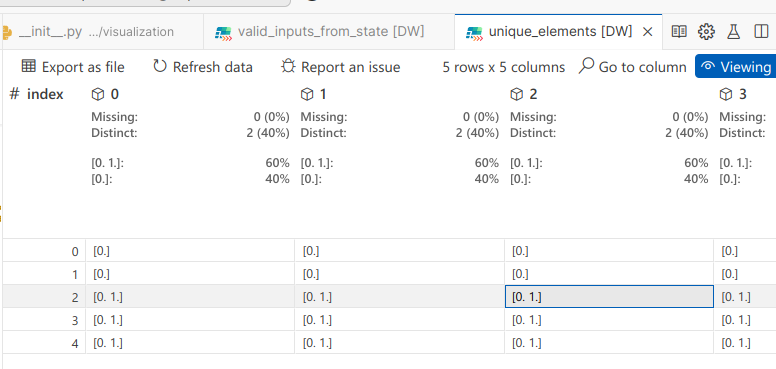

In [ ]:
# Map discrete bounds to box bounds
integer_dec_vars_mapping: dict[str, list[int]] = {f"var_{i}": np.empty((5, ), dtype=object) for i in range(discrete_bounds.shape[1])}
box_bounds_lower = np.zeros((5, 5), dtype=object) # (n steps, n inputs)
box_bounds_upper = np.empty((5, 5), dtype=object) # (n steps, n inputs)

for step_opt_idx in range(discrete_bounds.shape[0]): # Step
    for input_idx in range(discrete_bounds.shape[1]): # Input
        integer_dec_vars_mapping[f"var_{input_idx}"][step_opt_idx] = discrete_bounds[step_opt_idx, input_idx]
        box_bounds_upper[step_opt_idx, input_idx] = len(discrete_bounds[step_opt_idx, input_idx])-1

# {f"var_{i}": [0, len(discrete_bounds[i])-1] for i in range(len(discrete_bounds))}

display(integer_dec_vars_mapping)
display(box_bounds_lower)
display(box_bounds_upper)


{'var_0': array([array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
        array([0., 1.])], dtype=object),
 'var_1': array([array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
        array([0., 1.])], dtype=object),
 'var_2': array([array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
        array([0., 1.])], dtype=object),
 'var_3': array([array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
        array([0., 1.])], dtype=object),
 'var_4': array([array([0.]), array([0., 2.]), array([0., 1., 2.]),
        array([0., 1., 2.]), array([0., 1., 2.])], dtype=object)}

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=object)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 2],
       [1, 1, 1, 1, 2],
       [1, 1, 1, 1, 2]], dtype=object)